## Udacity Machine Learning Nanodegree
## Capstone Project: Dog Breed Classifier

#### George Xian Wee



## Project Definition

### Overview

This project originates from one of the capstone proposals provided by Udacity in the Machine Learning Engineer Nanodegree. It is a dog breed classifier which integrates several components to create a simple application to identify dogs and humans and to classify the type of dog breed, or the type of dog breed a human most closely resembles. The project falls under the research domain of image recognition, a field in machine learning where major breakthroughs have been achieved, such as a convolutional neural network (CNN) winning 2012 ImageNet Large Scale Recognition challenge. The training, validation and test dataset in this project was provided by Udacity.

### Problem Statement

The project primarily addresses classification problems using supervised learning. Input images are mostly of dogs and human faces but the application can actually accept any image. The first classification problem is to determine if an image contains a dog (the model will classify an image as dog or not dog). If there is a dog in the image, a convolutional neural network will take the dog image as an input and output a prediction of the breed of the dog. If there is not a dog in the image, the application will detect if there is a human face in the image and if one has been found, the CNN will guess which kind of dog breed the human face most closely resembles. In the case where an image does not contain a dog or human, the application will display a message noting this state.


### Metrics

In this project accuracy (number of correct predictions / total number of predictions) is used as the primary metric for evaluation and is suitable because the data is fairly balanced, meaning the training, validation and test data have roughly the same number of samples of dogs of each breed. A balanced dataset is important to avoid misleading accuracy results, such as as case in which 90% of the test data images are of a specific breed -  then a default prediction of that breed would yield 90% accuracy.


## Analysis

### Data Exploration and Visualization

The dataset contains 8351 dog images and 13233 human images. Each dog and human image in its raw form has R G B values and may vary in its pixel dimensions. For example, an image tensor could have the following dimensions: [1, 3, 224, 224], 1 image, a list RGB values of length 3 and width and length of 224.


In [68]:
import numpy as np
import pandas as pd
from glob import glob

human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

In [69]:
import cv2             
import matplotlib.pyplot as plt                        
%matplotlib inline                               

def display_image(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

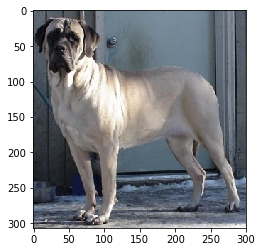

In [70]:
# Sample dog image
dog_img_path = dog_files[1]
display_image(dog_img_path)

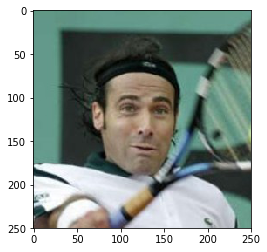

In [71]:
# Sample human image
human_img_path = human_files[1]
display_image(human_img_path)

## Methodology

### Data Preprocessing

The images were retrieved using the Python Image Library (PIL), resized, converted to tensors and normalized. After the image transformations, a sample dog or human image would have, for example, dimensions 1 x 3 x 224 x 224, meaning the first tensor would contain 3 tensors representing RGB values of a 224 x 224 image. Each pixel is an input into the initial layer of the neural network.

For the model built using transfer learning, images were transformed into uniform dimensions by first resizing them to 256 pixels and then center cropping to 224 pixels. Since PyTorch's ResNet model was used as the starting point for transfer learning, I used a similar transformation process and dimensions from its documentation https://pytorch.org/hub/pytorch_vision_resnet/. The images were normalized with mean values [0.485, 0.456, 0.406] and standard deviation values [0.229, 0.224, 0.225], which are also from ResNet's recommended mean and standard deviation values.

For the model built from scratch, the images were resized and cropped to 32 x 32 pixels to reduce training time and normalized with mean values [0.5, 0.5, 0.5] and standard deviation values [0.5, 0.5, 0.5].

In [1]:
import torch
from torchvision import datasets, transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_data(data_dir, options=None):
    '''
    Create training, validation and test data loaders and image datasets
    
    Args:
        data_dir: path to data directory
        options: preprocessing options
    
    Returns:
        Dictionaries of data loaders and image datasets
    '''
    
    batch_size = options['batch_size'] or 10
    shuffle = options['shuffle'] or False
    resize_dim = options['resize_dim'] or 256
    center_crop_dim = options['center_crop_dim'] or 224
    norm_mean = options['norm_mean'] or [0.5, 0.5, 0.5]
    norm_std = options['norm_std'] or [0.5, 0.5, 0.5]
    
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'
    
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(resize_dim),
            transforms.CenterCrop(center_crop_dim),
            transforms.ToTensor(),
            transforms.Normalize(mean=norm_mean, std=norm_std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(resize_dim),
            transforms.CenterCrop(center_crop_dim),
            transforms.ToTensor(),
            transforms.Normalize(mean=norm_mean, std=norm_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(resize_dim),
            transforms.CenterCrop(center_crop_dim),
            transforms.ToTensor(),
            transforms.Normalize(mean=norm_mean, std=norm_std)
        ])
    }
    
    dirs = {
        'train': train_dir,
        'valid': valid_dir,
        'test': test_dir
    }
    
    image_datasets = {
        x: datasets.ImageFolder(dirs[x], transform=data_transforms[x]) for x in ['train', 'valid', 'test']
    }
    
    data_loaders = {
        x: torch.utils.data.DataLoader(image_datasets[x], batch_size, shuffle) for x in ['train', 'valid', 'test'] 
    }

    return data_loaders, image_datasets

### Implementation and Refinement

First I defined, trained, validated and tested a convolutional neural network from scratch. The CNN contains 2 layers of convolutions which produce features used by a final, fully connected layer that takes in the features and outputs predictions. The first convolutional layer has 3 input channels to account for the 3 dimensions of R, G, B values, 6 output channels, a kernel size of 5 for each sliding filter and a stride of 1. Generally, odd numbers are chosen for kernel sizes in the convolutional layer to avoid distortions that occur across layers with even numbered kernel sizes. For example, common kernel sizes in convolutional layers are 3x3, 5x5 and 7x7. Smaller strides tend to encode more information and maintain translational invariance, meaning the effect of the position of the object in the image is reduced. The second convolutional layer has 6 input channels which is the same number of output channels as from layer 1, 16 output channels and a kernel size of 5.

To downsample, or to reduce the dimensionality of each layer, max pooling was used to obtain the maximum value from the activated features in the previous layer (the maximum activation). A kernel size and stride of 2 were chosen, which is consistent with common practice. A small kernel size and stride in pooling prevents discarding too much information from the previous layer.

Finally, fully connected layers take in the features from the convolutional layers and produces predictions. The input layer has 16 * 5 * 5 parameters (the number of outputs from the last convolutional layer multiplied by the dimension of the filters in the 2nd convolutional layer). The hidden layers consist of 120 and 84 neurons. There are a few empirically driven rules of thumb when choosing the number of hidden neurons. In general, the number of hidden neurons should be between the number of input and output parameters. Too few hidden neurons may result in underfitting and too many hidden neurons may lead to overfitting. A common rule is to have the number of hidden neurons be roughly the average of the number of neurons in the input and output layers. The output layer contains 133 neurons which corresponds to the 133 dog breeds in our dataset. Each neuron of the output layer is a probability assigned to each dog breed, with the highest probability representing the model’s prediction of the type of dog breed in the image.

In [73]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
  
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 133)
            
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [74]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass and get the output probabilities
            outputs = model(data)
            
            # get the loss 
            loss = criterion(outputs, target)
            
            # back propagation: backward pass to get the gradient
            # whole graph differentiated with respect to the loss
            loss.backward()

            # adjust each parameter weight
            optimizer.step()
            
            # accumulate the training loss
            # multiple the loss by the total number images per batch (data.size(0))
            # to get the total loss
            train_loss += loss.item() * data.size(0)
            
        ######################    
        # validate the model #
        ######################
        
        model.eval()

        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            # update the average validation loss
            valid_loss += loss.item() * data.size(0) 
        
        # compute average loss for training phase
        train_loss = train_loss / len(loaders['train'].dataset)
        
        # compute average loss for validation phase
        valid_loss = valid_loss / len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased from {:.6f} to {:.6f}, model saved.'.format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss

    return model

In [61]:
data_dir = '/data/dog_images'

options = {
    'batch_size': 64,
    'shuffle': True,
    'resize_dim': 36,
    'center_crop_dim': 32,
    'norm_mean': [0.5, 0.5, 0.5],
    'norm_std': [0.5, 0.5, 0.5]
}

data_loaders, image_datasets = load_data(data_dir, options)
loaders_scratch = data_loaders

In [62]:
# instantiate the CNN
model_scratch = Net()
model_scratch

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=133, bias=True)
)

In [63]:
# move tensors to GPU if CUDA is available

use_cuda = torch.cuda.is_available()

if torch.cuda.is_available():
    model_scratch.cuda()

In [64]:
from torch import nn, optim

# define loss function
criterion_scratch = nn.CrossEntropyLoss()

# define optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

In [36]:
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.892253 	Validation Loss: 4.891494
Validation loss decreased from inf to 4.891494, model saved.
Epoch: 2 	Training Loss: 4.891333 	Validation Loss: 4.890677
Validation loss decreased from 4.891494 to 4.890677, model saved.
Epoch: 3 	Training Loss: 4.890442 	Validation Loss: 4.889899
Validation loss decreased from 4.890677 to 4.889899, model saved.
Epoch: 4 	Training Loss: 4.889553 	Validation Loss: 4.889128
Validation loss decreased from 4.889899 to 4.889128, model saved.
Epoch: 5 	Training Loss: 4.888668 	Validation Loss: 4.888365
Validation loss decreased from 4.889128 to 4.888365, model saved.
Epoch: 6 	Training Loss: 4.887786 	Validation Loss: 4.887601
Validation loss decreased from 4.888365 to 4.887601, model saved.
Epoch: 7 	Training Loss: 4.886902 	Validation Loss: 4.886844
Validation loss decreased from 4.887601 to 4.886844, model saved.
Epoch: 8 	Training Loss: 4.886019 	Validation Loss: 4.886063
Validation loss decreased from 4.886844 to 4.886063, mo

In [65]:
# train with learning rate .01
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)

model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.892251 	Validation Loss: 4.889027
Validation loss decreased from inf to 4.889027, model saved.
Epoch: 2 	Training Loss: 4.885630 	Validation Loss: 4.883470
Validation loss decreased from 4.889027 to 4.883470, model saved.
Epoch: 3 	Training Loss: 4.878654 	Validation Loss: 4.875801
Validation loss decreased from 4.883470 to 4.875801, model saved.
Epoch: 4 	Training Loss: 4.859139 	Validation Loss: 4.845624
Validation loss decreased from 4.875801 to 4.845624, model saved.
Epoch: 5 	Training Loss: 4.767590 	Validation Loss: 4.705296
Validation loss decreased from 4.845624 to 4.705296, model saved.
Epoch: 6 	Training Loss: 4.617349 	Validation Loss: 4.561838
Validation loss decreased from 4.705296 to 4.561838, model saved.
Epoch: 7 	Training Loss: 4.458101 	Validation Loss: 4.431209
Validation loss decreased from 4.561838 to 4.431209, model saved.
Epoch: 8 	Training Loss: 4.348754 	Validation Loss: 4.339698
Validation loss decreased from 4.431209 to 4.339698, mo

The prediction results of a neural network built from scratch and trained over 25 epochs of 64 images per batch was quite low, only about 2% accuracy (21/836). More details are provided in the Evaluation section below.

To improve the performance, I employed fixed feature extraction, a form of transfer learning to extract the features from a pre-trained neural network, replace the final layer of the network and only optimize the weights of that layer. I started with a pre-trained neural network, ResNet18, a residual neural network, which is a convolutional neural network containing “skip connections” to simplify the network by using fewer layers for training and to avoid “vanishing gradients” problem in which the gradients in the early layers of a neural network become extremely small, inhibiting the network’s ability to accurately reflect how a small change in a parameter’s value will affect the output.

Next I replaced the final prediction layer of the network with a fully connected layer consisting of 512 input features (the output from the final convolutional layer of the model) and 133 output nodes (the number of dog breeds in our dataset). The final layer was re-trained with Cross Entropy Loss criterion and stochastic gradient descent optimizer to update the parameters with a learning rate (how much to adjust each parameter based on the gradient) of .001 and a momentum (the accumulation of previous gradients to determine how much to update the parameters) of .9, a common value used in practice. Learning rates (typically ranging from .1 - .001) that are larger enable models to train faster but may lead to suboptimal final weights while smaller learning rates train more slowly but may lead to better results. The result, discussed in the next section, substantially improved.

In [75]:
import torchvision.models as models

model_transfer = models.resnet18(pretrained=True)

for param in model_transfer.parameters():
    param.required_grad = False
    
num_features = model_transfer.fc.in_features

# Replace the final fully connected layer
model_transfer.fc = nn.Linear(num_features, 133)
print(model_transfer.fc)

Linear(in_features=512, out_features=133, bias=True)


In [76]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [77]:
# move model to GPU if CUDA is available
if use_cuda:
    model_transfer = model_transfer.cuda()

In [15]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001, momentum=0.9)

In [78]:
data_dir = '/data/dog_images'

options = {
    'batch_size': 64,
    'shuffle': True,
    'resize_dim': 256,
    'center_crop_dim': 224,
    'norm_mean': [0.485, 0.456, 0.406],
    'norm_std': [0.229, 0.224, 0.225]
}

data_loaders, image_datasets = load_data(data_dir, options)
loaders_transfer = data_loaders

In [64]:
# Results of training over 25 epochs with learning rate .001
n_epochs = 25
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.672806 	Validation Loss: 4.114409
Validation loss decreased from inf to 4.114409, model saved.
Epoch: 2 	Training Loss: 3.725128 	Validation Loss: 3.272928
Validation loss decreased from 4.114409 to 3.272928, model saved.
Epoch: 3 	Training Loss: 3.020625 	Validation Loss: 2.669618
Validation loss decreased from 3.272928 to 2.669618, model saved.
Epoch: 4 	Training Loss: 2.502269 	Validation Loss: 2.198346
Validation loss decreased from 2.669618 to 2.198346, model saved.
Epoch: 5 	Training Loss: 2.132495 	Validation Loss: 1.882919
Validation loss decreased from 2.198346 to 1.882919, model saved.
Epoch: 6 	Training Loss: 1.849949 	Validation Loss: 1.651998
Validation loss decreased from 1.882919 to 1.651998, model saved.
Epoch: 7 	Training Loss: 1.644703 	Validation Loss: 1.457477
Validation loss decreased from 1.651998 to 1.457477, model saved.
Epoch: 8 	Training Loss: 1.480561 	Validation Loss: 1.318219
Validation loss decreased from 1.457477 to 1.318219, mo

In [80]:
# Results of training over 25 epochs with learning rate .01
n_epochs = 25
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.01, momentum=0.9)

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 2.898901 	Validation Loss: 1.440444
Validation loss decreased from inf to 1.440444, model saved.
Epoch: 2 	Training Loss: 1.035991 	Validation Loss: 0.840980
Validation loss decreased from 1.440444 to 0.840980, model saved.
Epoch: 3 	Training Loss: 0.703839 	Validation Loss: 0.620466
Validation loss decreased from 0.840980 to 0.620466, model saved.
Epoch: 4 	Training Loss: 0.562393 	Validation Loss: 0.493286
Validation loss decreased from 0.620466 to 0.493286, model saved.
Epoch: 5 	Training Loss: 0.498291 	Validation Loss: 0.431919
Validation loss decreased from 0.493286 to 0.431919, model saved.
Epoch: 6 	Training Loss: 0.423802 	Validation Loss: 0.368312
Validation loss decreased from 0.431919 to 0.368312, model saved.
Epoch: 7 	Training Loss: 0.365013 	Validation Loss: 0.342664
Validation loss decreased from 0.368312 to 0.342664, model saved.
Epoch: 8 	Training Loss: 0.352193 	Validation Loss: 0.280487
Validation loss decreased from 0.342664 to 0.280487, mo

## Results

### Model Evaluation, Validation and Justification

To evaluate both the model created from scratch and the transfer learning model, I used the following validation process. I accumulated the loss during each forward pass and computed the average validation loss by dividing the total loss in each epoch by the number number of samples in the validation set. The model was validated on 835 images. To track the progress of the training, I accumulated the training loss in each epoch and calculated the average training loss. The model was trained on 6680 images.


For the convolutional network built and trained from scratch, the results were poor. After training for 25 epochs, the training loss only decreased from 4.892253 to 4.778899. Validation loss was reduced from 4.891494 to 4.778537. The results of the model on the test set was similar, a 4.752226 loss. The model was only able to achieve an accuracy of about 2% (21/836).

I then experimented with increasing the learning rate by an order of magnitude, to .01, to see if performance would improve. Over a course of 25 epochs, training loss was reduced to 3.113258 from 4.892251. Validation loss dropped from 4.889027 to 3.119743. Test loss was 0.498703 and the accuracy achieved by a model trained on a higher learning rate improved from 2% to about 8%.

The results from transfer learning were substantially better. In epoch 1, the training loss started at 4.672806 and by epoch 25, was reduced to 0.638552. The validation loss began at 4.114409 and ended at 0.576139. When the trained transfer model was tested on the test dataset, the model's loss was 0.787483 and achieved an accuracy of 82% (684/836). When the learning rate was increased to .01, training loss decreased from 2.898901 to 0.123613, validation loss decreased from 1.440444 to 0.092910 and the model accuracy ticked up to 83%.


In [17]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [66]:
# Test the model built from scratch
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.752226


Test Accuracy:  2% (21/836)


In [65]:
# Test the model built with transfer learning
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.787483


Test Accuracy: 82% (689/836)


In [67]:
# Test the model built from scratch trained with learning rate .01
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.536067


Test Accuracy:  8% (72/836)


In [81]:
# Test the model built with transfer learning trained with learning rate .01
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.498703


Test Accuracy: 83% (699/836)


In [82]:
# Saved model weights
model_transfer.fc.weight.data

tensor([[-4.3018e-02,  4.5302e-02, -5.4155e-02,  ...,  2.2628e-02,
         -1.4218e-02,  3.7860e-02],
        [-1.0022e-01,  9.5561e-02,  1.1751e-03,  ...,  1.3041e-02,
         -1.4440e-01,  1.0875e-02],
        [-8.0887e-02, -1.0498e-02,  2.9465e-02,  ...,  4.8710e-02,
         -5.9059e-03, -3.4602e-02],
        ...,
        [ 5.4947e-02,  2.6537e-02, -2.2674e-02,  ..., -1.5200e-02,
         -1.4457e-02, -7.7843e-02],
        [-3.1291e-02,  4.2099e-02, -1.7785e-02,  ...,  5.4054e-03,
         -4.4663e-02,  5.9256e-02],
        [ 6.1107e-02, -4.9036e-02, -6.8313e-02,  ..., -7.2585e-02,
         -5.8785e-02,  1.5374e-01]], device='cuda:0')

### Build model from saved weights

In [26]:
import torchvision.models as models

# Get saved model and rebuild the model from saved weights
# To check final layer's weights: model_transfer.fc.weight.data
model_transfer = models.resnet18(pretrained=True)

for param in model_transfer.parameters():
    param.required_grad = False
    
num_features = model_transfer.fc.in_features

model_transfer.fc = nn.Linear(num_features, 133)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

In [27]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [28]:
# define loss function
criterion_transfer = nn.CrossEntropyLoss()

In [29]:
# test loaded model 
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.772357


Test Accuracy: 82% (689/836)


### Use trained model to make a prediction

In [83]:
from PIL import Image

def predict_dog_breed(img_path):
    """Predict breed of the dog from the image
        
        Args:
            img (JPG): image to predict
        
        Returns:
            dog_breed(str): return the dog breed prediction
    """    
    # load the image as a JpegImageFile
    img_pil = Image.open(img_path)
        
    # preprocess - resize, crop, convert to tensor, normalize
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # preprocess - convert jpeg to tensor and other transformations
    img_tensor = preprocess(img_pil)
    
    # on axis 0 (rows), axis 1 (columns)
    # before unsqueeze: torch.Size([3, 224, 224])
    # after unsqueeze(0): torch.Size([1, 3, 224, 224]) 
    # after unsqueeze(1): torch.Size([3, 1, 224, 224])
    input_batch = img_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        
    fc_out = model_transfer(input_batch)
    
    # get the highest output probability
    pred_idx = fc_out.data.argmax().item()
    
    return pred_idx

### Demo of Application

In [84]:
import torch
from PIL import Image
from torchvision import transforms

def detect_dog(img_path):
    """Detect if image contains a dog
    Args:
        img_path(str): path to image
    Returns:
        is_dog(bool): Returns is_dog. True if dog, False if not dog.
    """

    # move model to GPU if CUDA is available
    use_cuda = torch.cuda.is_available()

    # load the image as a JpegImageFile
    img_pil = Image.open(img_path)
        
    # preprocess - resize, crop, convert to tensor, normalize
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # preprocess - convert jpeg to tensor and other transformations
    img_tensor = preprocess(img_pil)

    input_batch = img_tensor.unsqueeze_(0)
    
    # define vgg16 model
    VGG16 = models.vgg16(pretrained=True)

    if use_cuda:
        input_batch = input_batch.to('cuda')
        VGG16 = VGG16.cuda()

    output = VGG16(input_batch)
    
    pred_idx = None
    # get the highest output probability
    if use_cuda:
        pred_idx = output.data.argmax().item()
    else:
        pred_idx = output.data.numpy().argmax()

    # index range of dog breeds from ImageNet: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
    return 151 <= pred_idx <= 268

In [85]:
import cv2 # OpenCV  

def detect_human(img_path):
    """Detect if image contains a human
    Args:
        processed_img(JPEG): image to predict
    Returns:
        is_human(bool): Returns is_human. True if human, False if not human
    """

    # pre-trained face detector
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')  
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)

    return len(faces) > 0

In [86]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    """Application: Preprocess, Predict
    Args:
        Img_path (str): path to image

    Returns:
        None: Outputs result of predictions 
    """

    is_dog = detect_dog(img_path)

    if is_dog:
        print('Dog detected!')
        dog_breed = predict_dog_breed(img_path)
        class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]
        idx_to_class = {idx: breed for idx, breed in enumerate(class_names)}
        print('Dog breed: ', idx_to_class[dog_breed])
        display_image(img_path)
    else: 
        is_human = detect_human(img_path)
        
        if is_human:
            print('Human detected!')
            display_image(img_path)
            dog_breed_resemblance = predict_dog_breed(img_path)
            class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]
            idx_to_class = {idx: breed for idx, breed in enumerate(class_names)}
            dog_breed_resembled = idx_to_class[dog_breed_resemblance]
            file_paths = [file for file in dog_files if dog_breed_resembled.replace(' ', '_') in file]
            if file_paths:
                print('Dog breed resembled: ', dog_breed_resembled)
                display_image(file_paths[0])
                
            else:
                print('No image path found')
            
        else:
            print('Not a dog or human')


Dog detected!
Dog breed:  Labrador retriever


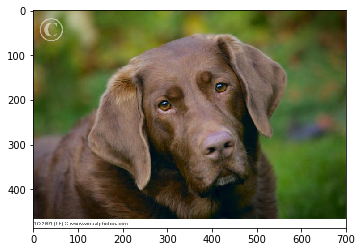

In [101]:
# Example 1: Dog image
# Ground truth, as indicated in file path is Labrador Retriever
user_img_path = './images/Labrador_retriever_06455.jpg'
run_app(user_img_path)

Dog detected!
Dog breed:  Brittany


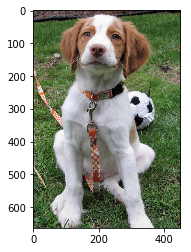

In [102]:
# Example 2: Dog image
# Ground truth, as indicated in file path is Brittany
user_img_path = './images/Brittany_02625.jpg'
run_app(user_img_path)

Dog detected!
Dog breed:  Welsh springer spaniel


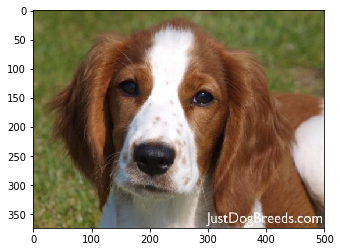

In [103]:
# Example 3: Dog image
# Ground truth, as indicated in file path is Welsh Springer Spaniel
user_img_path = './images/Welsh_springer_spaniel_08203.jpg'
run_app(user_img_path)

Human detected!


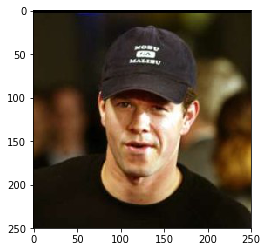

Dog breed resembled:  Doberman pinscher


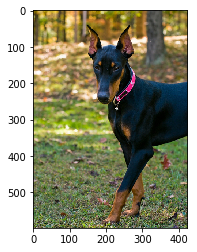

In [104]:
# Example 4: Human image
# Image of an actor Mark Wahlberg
user_img_path = '/data/lfw/Mark_Wahlberg/Mark_Wahlberg_0001.jpg'
run_app(user_img_path)

Human detected!


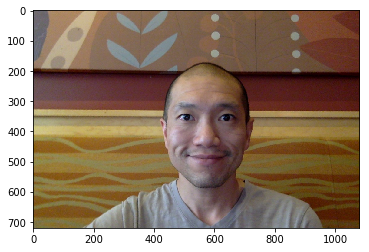

Dog breed resembled:  Maltese


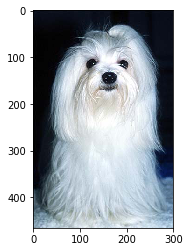

In [105]:
# Example 5: Human image
# Image of George 
user_img_path = './images/george_w.jpg'
run_app(user_img_path)

## Conclusion

In this project, images of dogs were preprocessed, a convolutional neural network was trained, validated and tested, and a function was written to simulate an application that takes in an input image path, predict the breed of the dog or the type of breed a human most closely resembles.
Building a convolutional neural network that can achieve high accuracy from scratch was tougher than I expected. Initially I thought that by increasing the learning rate, I could increase the accuracy, which did occur but only up to a point. To improve the results of the model trained from scratch, I can try adding more convolutional layers and to boost the accuracy of the transfer model, perhaps I can experiment with adding more hidden layers to the final fully connected layers of the network.



#### Sources:

http://cs231n.github.io/convolutional-networks/ http://giant.uji.es/blog/convnet/convnet.html

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-net

https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

https://www.quora.com/How-can-I-decide-the-kernel-size-output-maps-and-layers-of-CNN

https://arxiv.org/pdf/1606.02228v2.pdf https://www.quora.com/How-does-one-determine-stride-size-in-CNN-filters 

https://stats.stackexchange.com/questions/207195/translational-variance-in-convolutional-neural-networks 

https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7 

https://www.quora.com/Are-maxpooling-layer-kernel-sizes-in-CNNs-generally-smaller-than-convolutional-layer-kernel-sizes-Why 

https://www.kaggle.com/pytorch/resnet18 

https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33 

https://www.quora.com/What-is-the-vanishing-gradient-problem 

https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d